# IMPORTS AND GENERAL FUNCTIONS

In [ ]:
# default_exp preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import glob
import os
import chart_studio.plotly as py
import plotly.graph_objects as go
import missingno as msno
import itertools 
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble  import RandomForestRegressor

In [ ]:
#export
def re_assert_cod_datatypes(df):
    dtypes = {
        "COD_DPTO":"object",
        "COD_MUNICIPIO":"object",
        "SEMANA":"object",
        "ANO":"object",
        "DENGUE":"UInt16",
        "DENGUE GRAVE":"UInt16",
        "MORTALIDAD POR DENGUE":"UInt8",
        "CODIGOESTACION":"object"
    }
    for col in df.columns:
        if col in dtypes.keys():
            df[col] = df[col].astype(dtypes[col])
            if col == "SEMANA":
                df[col] = df[col].apply(lambda x: str(x).zfill(2))
    return df

In [ ]:
#export
def get_sivigila_calendar():
    date = pd.to_datetime("2006-01-01")
    week = 1
    weeks = []
    year = 2006
    sivigila_53_years = [2008, 2014, 2020]
    day = 1
    while year < 2021:
        if week == 53:
            if not (year in sivigila_53_years):
                year+=1
                week = 1
            
        elif week > 53:
            year+=1
            week = 1
        #if day == 1:
        #    year = date.year
        weeks.append( (date,year,week) )
        day+=1
        if day==8:
            week += 1
            day = 1
        date += pd.DateOffset(days=1)
    columns = ["FECHA","ANO","SEMANA"]
    df_weeks = pd.DataFrame(weeks, columns=columns)
    df_weeks = df_weeks.set_index("FECHA")
    df_weeks = re_assert_cod_datatypes(df_weeks)
    return df_weeks

# EXTRACTING DENGUE DATA FROM SIVIGILA FILE YEARS 2007 to 2020

In [ ]:
#export
def unify_column_names_dengue(columns):
    new_columns = []
    for col in columns:
        if "evento" == col.lower():
            new_columns.append("NOMBRE")
        elif "cod_e" in col.lower():
            new_columns.append("COD_EVE")
        elif "cod_d" in col.lower():
            new_columns.append("COD_DPTO")
        elif "cod_m" in col.lower():
            new_columns.append("COD_MUNICIPIO")
        elif "dato" in col.lower() or "conteo" in col.lower():
            new_columns.append("TOTAL_CASOS")
        else:
            new_columns.append(col.upper())
    return new_columns



def get_dengue_weeks_from_rutinaria(filename, codes, sheet_num):
    df = pd.read_excel(filename, sheet_name = sheet_num)
    df.columns = unify_column_names_dengue(list(df.columns))
    df = df[~df["COD_DPTO"].isin([0,1])]
    df = df[df.COD_EVE.isin(codes)]
    df_pivoted = df.pivot_table(values = "TOTAL_CASOS", columns = "NOMBRE", index = ["ANO","COD_DPTO","COD_MUNICIPIO","SEMANA"]).reset_index()
    
    return df_pivoted


def read_all_rutinarias(codes = [210,220, 580]):
    dfs = []
    for year in range(2007,2019):
        print("Doing year ", year)
        filename = "local/data/rutinarias_dengue/rutinaria_{}.xlsx".format(year)
        df = get_dengue_weeks_from_rutinaria(filename, codes, sheet_num = 3)
        df = re_assert_cod_datatypes(df)
        
        dfs.append(df)
    df = pd.concat(dfs)
    df.columns.name = None
    return re_assert_cod_datatypes(df)

In [ ]:
df_calendar = get_sivigila_calendar()
df_calendar_weekly = get_sivigila_calendar().drop_duplicates(subset=["ANO","SEMANA"])

In [ ]:
df_dengue_2007_2018 = read_all_rutinarias()

In [ ]:
df_dengue_2007_2018.to_csv("local/data/df_dengue_07_18.csv")

In [ ]:
df_dengue_2007_2018 = re_assert_cod_datatypes(df_dengue_2007_2018)

In [ ]:
def get_time_series_from_municipio_subset(subset_mun, event_col_n, cod_eve, year = 2019):
    weeks_year = {2019:52,2020:16}
    try:
        series_index = get_index_from_col_and_string(subset_mun, subset_mun.columns[event_col_n], cod_eve)
        series = list(subset_mun.loc[series_index,:][6:])
    except:
        series = [0]*weeks_year[year]
    return series
    
def get_index_from_col_and_string(df, col,string):
    return df[df.loc[:,col]==string].index[0]

In [ ]:
wb = pd.read_excel("local/data/rutinarias_dengue/rutinaria_2019.xlsx")
for col in wb.columns[3:4]:
    if np.sum(wb.loc[:,col].str.contains("CALI")):
        mun_col = col
        break       

lista_municipios = list(wb.loc[:,col].unique())
lista_municipios = lista_municipios[lista_municipios.index("* ANTIOQUIA. MUNICIPIO DESCONOCIDO"):]
lista_municipios = [ (lista_municipios[i],lista_municipios[i+1]) for i in range(0,len(lista_municipios),2) ]

## YEAR 2019

In [ ]:
def dataframe_from_dengue_series(series, value_name):
    cols = ["ANO","COD_DPTO","COD_MUNICIPIO"]+[str(i) for i in range(1,53)]
    df = pd.DataFrame(series).transpose()
    df.columns=cols
    df = pd.melt(df, id_vars = ["ANO","COD_DPTO","COD_MUNICIPIO"], var_name = "SEMANA", value_name=value_name)
    return df


dfs = []
for i,mun in enumerate(lista_municipios):
    index1_mun = get_index_from_col_and_string(wb, mun_col, mun[0])
    index2_mun = get_index_from_col_and_string(wb, mun_col, mun[1])
    subset_mun = wb.loc[index1_mun:index2_mun-1, :]
    subset_mun = subset_mun.iloc[:,:-1]
    if not (subset_mun.iloc[0,0] is np.nan):
        cod_depto = int(subset_mun.iloc[0,0])
        if cod_depto in [48, 9, 14]:
            cod_depto-=1
    
    cod_municipio = str(cod_depto).zfill(2) + str(subset_mun.iloc[0,2]).zfill(3)
    den_mort_series = get_time_series_from_municipio_subset(subset_mun, 4 ,"580")
    dengue_series = get_time_series_from_municipio_subset(subset_mun, 4 ,"210")
    den_grave_series = get_time_series_from_municipio_subset(subset_mun, 4,"220")
    dengue_series = [2019, cod_depto, cod_municipio] + dengue_series
    den_mort_series = [2019, cod_depto, cod_municipio] + den_mort_series
    den_grave_series =  [2019, cod_depto, cod_municipio] + den_grave_series
    df_dengue = dataframe_from_dengue_series(dengue_series, value_name = "DENGUE")
    df_dengue_grave = dataframe_from_dengue_series(den_grave_series, value_name = "DENGUE GRAVE")
    df_den_mort = dataframe_from_dengue_series(den_mort_series, value_name = "MORTALIDAD POR DENGUE")
    df_dengue["DENGUE GRAVE"] = df_dengue_grave["DENGUE GRAVE"]
    df_dengue["MORTALIDAD POR DENGUE"]  = df_den_mort["MORTALIDAD POR DENGUE"]
    dfs.append(df_dengue)

df_dengue_2019 = pd.concat(dfs, axis = 0)
del dfs

In [ ]:
df_dengue_2019 = re_assert_cod_datatypes(df_dengue_2019)

## YEAR 2020

In [ ]:
wb = pd.read_excel("local/data/rutinarias_dengue/rutinaria_2020.xlsx", sheet_name = 1)

In [ ]:
wb = wb.iloc[2:,2:]

for col in wb.columns[3:4]:
    if np.sum(wb.loc[:,col].str.contains("CALI")):
        mun_col = col
        break     

lista_municipios = list(wb.loc[:,col].unique())

lista_municipios = lista_municipios[lista_municipios.index("* ANTIOQUIA. MUNICIPIO DESCONOCIDO"):]
lista_municipios = [ (lista_municipios[i],lista_municipios[i+1]) for i in range(0,len(lista_municipios),2) ]

In [ ]:
def dataframe_from_dengue_series(series, value_name):
    cols = ["ANO","COD_DPTO","COD_MUNICIPIO"]+[str(i) for i in range(1,17)]
    df = pd.DataFrame(series).transpose()
    df.columns=cols
    df = pd.melt(df, id_vars = ["ANO","COD_DPTO","COD_MUNICIPIO"], var_name = "SEMANA", value_name=value_name)
    return df
dfs = []
for i,mun in enumerate(lista_municipios):
    index1_mun = get_index_from_col_and_string(wb, mun_col, mun[0])
    index2_mun = get_index_from_col_and_string(wb, mun_col, mun[1])
    subset_mun = wb.loc[index1_mun:index2_mun-1, :]
    subset_mun = subset_mun.iloc[:,:-1]
    if not (subset_mun.iloc[0,0] is np.nan):
        cod_depto = subset_mun.iloc[0,0]
        if cod_depto in [48, 9, 14]:
            cod_depto-=1
    cod_municipio = str(cod_depto).zfill(2) + str(subset_mun.iloc[0,2]).zfill(3)
    den_mort_series = get_time_series_from_municipio_subset(subset_mun, 4 ,"580", 2020)
    dengue_series = get_time_series_from_municipio_subset(subset_mun, 4 ,"210", 2020)
    den_grave_series = get_time_series_from_municipio_subset(subset_mun, 4,"220",2020)
    dengue_series = [2020, cod_depto, cod_municipio] + dengue_series
    den_mort_series = [2020, cod_depto, cod_municipio] + den_mort_series
    den_grave_series =  [2020, cod_depto, cod_municipio] + den_grave_series
    df_dengue = dataframe_from_dengue_series(dengue_series, value_name = "DENGUE")
    df_dengue_grave = dataframe_from_dengue_series(den_grave_series, value_name = "DENGUE GRAVE")
    df_den_mort = dataframe_from_dengue_series(den_mort_series, value_name = "MORTALIDAD POR DENGUE")
    df_dengue["DENGUE GRAVE"] = df_dengue_grave["DENGUE GRAVE"]
    df_dengue["MORTALIDAD POR DENGUE"]  = df_den_mort["MORTALIDAD POR DENGUE"]
    dfs.append(df_dengue)
df_dengue_2020 = pd.concat(dfs, axis = 0)
del dfs

In [ ]:
df_dengue_2020 = re_assert_cod_datatypes(df_dengue_2020)
df_dengue_2020.head()

,ANO,COD_DPTO,COD_MUNICIPIO,SEMANA,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
0,2020,05,05000,01,0,0,0
1,2020,05,05000,02,0,0,0
2,2020,05,05000,03,0,0,0
3,2020,05,05000,04,0,0,0
4,2020,05,05000,05,0,0,0


In [ ]:
df_dengue_2007_2020 = pd.concat([df_dengue_2007_2018, df_dengue_2019, df_dengue_2020])
df_dengue_2007_2020 = re_assert_cod_datatypes(df_dengue_2007_2020)
df_dengue_2007_2020["COD_MUNICIPIO"] = df_dengue_2007_2020["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))

In [ ]:
df_dengue_2007_2020

,ANO,COD_DPTO,COD_MUNICIPIO,SEMANA,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
0,2007,5,05000,02,1,<NA>,<NA>
1,2007,5,05000,03,<NA>,2,<NA>
2,2007,5,05000,04,4,<NA>,<NA>
3,2007,5,05000,05,11,<NA>,<NA>
4,2007,5,05000,06,4,2,<NA>
...,...,...,...,...,...,...,...
11,2020,99,99773,12,0,0,0
12,2020,99,99773,13,1,0,0
13,2020,99,99773,14,0,0,0
14,2020,99,99773,15,0,0,0


In [ ]:
def get_composite_city_code(x):
    dept_code = x["COD_DPTO"]
    city_code = x["COD_MUNICIPIO"]
    composite_code = str(x["COD_DPTO"]).zfill(2) + str(x["COD_MUNICIPIO"]).zfill(3) 
    x["COD_MUNICIPIO"] = composite_code
    return x 
df_cities = pd.read_csv("local/data/DepartamentosMunicipios.csv")[["COD_DPTO","COD_MUNICIPIO"]]
df_cities = df_cities[~df_cities["COD_DPTO"].isin([0,1])]
df_cities = df_cities.apply(get_composite_city_code, axis = 1)
df_cities.head(1)

,COD_DPTO,COD_MUNICIPIO
0,91,91000


In [ ]:
def combine_cities_and_weeks(df_weeks, df_cities):
    dfs_week_city = []
    for city in df_cities.iterrows():
        df_week_city = df_weeks.copy()
        df_week_city["COD_MUNICIPIO"] = city[1][1]
        df_week_city["COD_DPTO"] = city[1][0]
        dfs_week_city.append(df_week_city)
    res = pd.concat(dfs_week_city, axis = 0)
    return res
df_weeks_cities = combine_cities_and_weeks(df_calendar_weekly, df_cities)
df_weeks_cities["COD_MUNICIPIO"] = df_weeks_cities["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_dengue_2007_2020["COD_MUNICIPIO"] = df_dengue_2007_2020["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_weeks_cities["SEMANA"] = df_weeks_cities["SEMANA"].apply(lambda x: str(x).zfill(2))
df_dengue_2007_2020["SEMANA"] = df_dengue_2007_2020["SEMANA"].apply(lambda x: str(x).zfill(2))
df_weeks_cities["ANO"] = df_weeks_cities["ANO"].apply(lambda x: str(x).zfill(4))
df_dengue_2007_2020["ANO"] = df_dengue_2007_2020["ANO"].apply(lambda x: str(x).zfill(4))
df_weeks_cities = re_assert_cod_datatypes(df_weeks_cities)
df_weeks_cities.tail(1)

,ANO,SEMANA,COD_MUNICIPIO,COD_DPTO
FECHA,,,,
2021-01-03,2021,01,99624,99


In [ ]:
def combine_cities_weeks_and_dengue(df_weeks_cities, df_dengue):
    den_columns = ["ANO","SEMANA","COD_DPTO","COD_MUNICIPIO","DENGUE", "DENGUE GRAVE", "MORTALIDAD POR DENGUE"]
    res = pd.merge(left=df_weeks_cities.reset_index(), 
                   right = df_dengue[den_columns], 
                   how = "left", 
                   on = ["ANO","SEMANA","COD_MUNICIPIO"],
                   suffixes=('', '_y')
                  )

    res = res.drop(res.filter(regex='_y$').columns.tolist(),axis=1)
    res = res.set_index("FECHA")
    return res
df_dengue_city_week = combine_cities_weeks_and_dengue(df_weeks_cities, df_dengue_2007_2020)
df_dengue_city_week = df_dengue_city_week.fillna(0)

In [ ]:
df_dengue_city_week.head()

,ANO,SEMANA,COD_MUNICIPIO,COD_DPTO,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
FECHA,,,,,,,
2006-01-01,2006,01,91000,91,0,0,0
2006-01-08,2006,02,91000,91,0,0,0
2006-01-15,2006,03,91000,91,0,0,0
2006-01-22,2006,04,91000,91,0,0,0
2006-01-29,2006,05,91000,91,0,0,0


In [ ]:
df_dengue_city_week.to_csv("local/data/dengue_weekly_2007_2020.csv", index = True)

# METEREOLOGICAL DATA

In [ ]:
#export
def read_csv_IDEAM(filenames, sep = r";|,"):
    """
    This function receives a list of .csv files downloaded from http://dhime.ideam.gov.co/atencionciudadano/ 
    and combines information into a single pandas dataframe by keeping only the date and the relevant data column.
    
    -filenames: list of one or more filenames of .csv files.
    -codigo_estacion: the code of the station we are interested in.
    -sep: the kind of separation used for pd.read_csv, it is good to try and switch between ; and , if there is any trouble since
          the not all files downloaded from IDEAM have the same separator.
          
    returns: a dataframe with the datetime column as it index, and the V
    """
    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename, sep, dtype={'Calificador': 'object','Latitud': 'object'}))
    if len(dfs) > 0:
        df = pd.concat(dfs, axis = 0).reset_index(drop=True)
    else:
        df = dfs[0]
    return df

def get_variable_IDEAM(df, possible_var_names, standard_var_name, codigo_estacion = None):
    df = df[df["Etiqueta"].isin(possible_var_names)].reset_index(drop=True)
    value_name = df.loc[0,"Etiqueta"]
    if codigo_estacion:
        df = df[(df["CodigoEstacion"] == codigo_estacion)]
    df = df[["CodigoEstacion","Fecha","Valor"]]
    df.columns = ["CodigoEstacion","DATE",standard_var_name]
    df.index = pd.to_datetime(df["DATE"], dayfirst = False)
    df = df.drop_duplicates()
    del(df["DATE"])
    return df

def filter_entries_by_column_index_values(df, column_name, min_val = None, max_val = None):
    if min_val and max_val:
        df = df[(df[column_name] >= min_val) & (df[column_name] <= max_val) ]
        return df
    elif not min_val:
        df = df[(df[column_name] <= max_val) ]
        return df
    elif not max_val:
        df = df[(df[column_name] >= min_val) ]
        return df
    else:
        return df
    
def combine_IDEAM_stations(df_all, stations_priority):
    df_st = df_all[df_all["CodigoEstacion"]==stations_priority[0]]
    if len(df_all) == 1:
        return df_st
    for station in stations_priority[1:]:
        df_st_add = df_all[df_all["CodigoEstacion"]==station]
        df_st_add = df_st_add[(~df_st_add.index.isin(df_st.index))]
        df_st = pd.concat([df_st, df_st_add])
    del df_st["CodigoEstacion"]
    return df_st

def aggregate_data(df, agg_type = 'daily', aggregations = [np.mean, np.max, np.min, 'count'], min_count = None):
    if agg_type == 'daily':
        df_aggregated = df.groupby([df.index.date]).agg(aggregations)
        df_aggregated.columns = ["_".join(x).upper() for x in df_aggregated.columns.ravel()]
        if min_count:
            df_aggregated = df_aggregated[(df_aggregated.iloc[:,-1] >= min_count)]
        df_aggregated.index = pd.to_datetime(df_aggregated.index)
    return df_aggregated.iloc[:,:-1]

def drop_duplicates_by_date_station(df):
    df = df.reset_index() 
    df = df.drop_duplicates(subset=["DATE","CodigoEstacion"])
    df = df.set_index("DATE")
    return df
def highlight_max(s):
    '''
    highlight the maximum in a Series coral.
    '''
    is_max = s == s.max()
    return ['background-color: coral' if v else '' for v in is_max]

In [ ]:
df_dengue_city_week = pd.read_csv("local/data/dengue_weekly_2007_2020.csv")
df_dengue_city_week.head()

,FECHA,ANO,SEMANA,COD_MUNICIPIO,COD_DPTO,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
0,2006-01-01,2006,1,91000,91,0,0,0
1,2006-01-08,2006,2,91000,91,0,0,0
2,2006-01-15,2006,3,91000,91,0,0,0
3,2006-01-22,2006,4,91000,91,0,0,0
4,2006-01-29,2006,5,91000,91,0,0,0


In [ ]:
df_dengue_city_week[["DENGUE","DENGUE GRAVE","MORTALIDAD POR DENGUE"]].sum()

DENGUE                   993978
DENGUE GRAVE              41212
MORTALIDAD POR DENGUE      1304
dtype: int64

In [ ]:
df_sm = df_dengue_city_week[df_dengue_city_week["COD_MUNICIPIO"]==76001]
df_sm.index = df_sm.FECHA

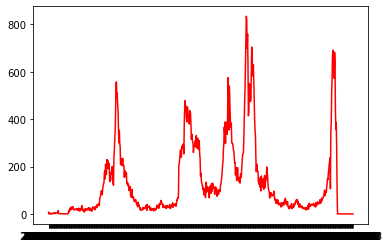

In [ ]:
#plt.plot(df_sm[df_sm["ANO"]==2018]["DENGUE"], color = "blue")
plt.plot(df_sm[df_sm["ANO"]>=2007]["DENGUE"], color = "red")

# Workflow con datos del mapa del IDEAM

Poner en una única carpeta todos los archivos descargados para una ubicación dada.

Estoy trabajando en lograr que las descargas de la API queden con los mismos campos que las del IDEAM.

Las variables son: 

- "HRA2_AUT_60" <- HUMEDAD RELATIVA A 2 METROS, HORARIA
- "TA2_AUT_60" <- TEMPERATURA A 2 METROS, HORARIA
- "PTPM_CON" <- PRECIPITACIÓN, DIARIA
- "VV_AUT_2" <- VELOCIDAD DLE VIENTO CADA DOS MINUTOS

En todos los casos habrá que combinar datos de varias estaciones, los criterios preferibles son:

1. Correlación (implementación pendiente)
2. Proximidad en altitud (dato solo disponible para las estaciones del mapa del IDEAM)
3. Proximidad en longitud y latitud.

In [ ]:
municipality_name = "BARRANQUILLA"
cod_municipio = 8001
foldername = "./local/data/SOLEDAD_BARRANQUILLA_DATA_V2/"
filenames = sorted(glob.glob(foldername+'*.csv'))
df = read_csv_IDEAM(filenames).drop_duplicates()
df.head(1)
df.columns

Index(['CodigoEstacion', 'NombreEstacion', 'Latitud', 'Longitud', 'Altitud',
       'Categoria', 'Entidad', 'AreaOperativa', 'Departamento', 'Municipio',
       'FechaInstalacion', 'FechaSuspension', 'IdParametro', 'Etiqueta',
       'DescripcionSerie', 'Frecuencia', 'Fecha', 'Valor', 'Grado',
       'Calificador', 'NivelAprobacion'],
      dtype='object')

In [ ]:
df.drop_duplicates(subset=["CodigoEstacion"])

,CodigoEstacion,NombreEstacion,Latitud,Longitud,Altitud,Categoria,Entidad,AreaOperativa,Departamento,Municipio,...,FechaSuspension,IdParametro,Etiqueta,DescripcionSerie,Frecuencia,Fecha,Valor,Grado,Calificador,NivelAprobacion
0,29004520,ESCUELA NAVAL BARRANQUILLA - AUT [29004520],11.00638889,-74.785000,10.0,Climática Principal,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 02 - Atlántico-Bolivar-Sucre,Atlantico,Barranquilla,...,NaN,HUM RELATIVA,HRA2_AUT_60,Humedad relativa del aire a 2 metros horaria,Horaria,2018-10-02 01:00,94.0,50.0,NaN,900.0
15835,29040450,BARRANQUILLA SEDE [29040450],10.99761111,-74.796722,12.0,Pluviométrica,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 02 - Atlántico-Bolivar-Sucre,Atlantico,Barranquilla,...,NaN,PRECIPITACION,PTPM_CON,Día pluviométrico,Diaria,2007-01-01 00:00,0.0,50.0,NaN,900.0
17290,29045120,FLORES LAS [29045120],11.04,-74.820833,8.0,Climática Principal,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 02 - Atlántico-Bolivar-Sucre,Atlantico,Barranquilla,...,NaN,PRECIPITACION,PTPM_CON,Día pluviométrico,Diaria,2006-01-02 00:00,0.0,50.0,NaN,900.0
65278,29045190,AEROPUERTO E. CORTISSOZ - AUT [29045190],10.91777778,-74.779722,14.0,Sinóptica Principal,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...,Area Operativa 02 - Atlántico-Bolivar-Sucre,Atlantico,Soledad,...,NaN,HUM RELATIVA,HRA2_AUT_60,Humedad relativa del aire a 2 metros horaria,Horaria,2013-05-07 18:00,79.0,50.0,NaN,900.0
182199,29045180,LAS FLORES,11.039,-74.820000,NaN,%,NaN,<nil>,ATLÁNTICO,BARRANQUILLA,...,NaN,NaN,Humedad del aire 2 mt,NaN,NaN,2017-10-01T16:00:00.000,84.0,NaN,NaN,NaN
509787,29047000,TEBSA TX GPRS,10.937,-74.760000,NaN,mm,NaN,BAJO MAGDALENA,ATLÁNTICO,SOLEDAD,...,NaN,NaN,Precipitacion,NaN,NaN,2016-12-31T00:00:00.000,0.0,NaN,NaN,NaN


# Workflow precipitación

1. Lectura y visualización inicial:

In [ ]:
standard_var_name = "PRECIPITATION"
possible_prec_names = ["PTPM_CON","Precipitacion"]
df_prec = get_variable_IDEAM(df, possible_prec_names, standard_var_name)

In [ ]:
df_prec = drop_duplicates_by_date_station(df_prec)

In [ ]:
fig = go.Figure()
for df_group in df_prec.groupby(["CodigoEstacion"]):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_lluvia = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name], name ="PP "+str(codigoestacion), mode = "lines")
    fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY " +standard_var_name + " IN " + municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()#16015010

In [ ]:
df_prec_daily = df_prec 
df_prec_daily.head()

,CodigoEstacion,PRECIPITATION
DATE,,
2007-01-01,29040450,0.0
2007-01-02,29040450,0.0
2007-01-03,29040450,0.0
2007-01-04,29040450,0.0
2007-01-05,29040450,0.0


### Escoger hasta 6 estaciones para el análisis de correlación, en caso de que hayan muchas estaciones, sino basta con utilizar el unique

In [ ]:
stations_corr = df_prec_daily["CodigoEstacion"].unique()

#stations_corr = [26055120, 26080310, 26085170] CALI
#stations_corr = [15010501, 15015050, 15015120] sama
#stations_corr = [35030380, 35030370,35030100, 35035020] villav
#stations_corr =  [16015010, 16015110, 16015501 ]
#stations_corr = [27015330, 27015270, 27011270]
stations_corr = [29004520, 29040450, 29045190]
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_prec_daily[df_prec_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['PRECIPITATION'],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['PRECIPITACION'] = corr_table.corr().iloc[0,1]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(highlight_max, axis=1)
all_corr_df

29004520            29040450
               29040450  29045190  29045190
PRECIPITACION  0.663355  0.257235  0.408919

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.

In [ ]:
# stations_priority =[26055120,26080310] Cali
stations_priority = [29004520, 29040450] # Barranquilla
df_prec_daily = combine_IDEAM_stations(df_prec_daily, stations_priority).sort_index()
df_prec_daily = df_prec_daily.resample('D').mean()

In [ ]:
fig = go.Figure()
plot_lluvia = go.Scatter(x=df_prec_daily.index,
            y=df_prec_daily[standard_var_name], name ="PP ", mode = "lines")
fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

3. Variables compuestas o derivadas de los valores diarios

# Workflow temperatura

In [ ]:
standard_var_name = "TEMPERATURE"
possible_temp_names = ["TA2_AUT_60", "Temp Aire 2 m"]
df_temp = get_variable_IDEAM(df, possible_temp_names, standard_var_name).sort_index()
df_temp = drop_duplicates_by_date_station(df_temp)
df_temp.tail(1)

,CodigoEstacion,TEMPERATURE
DATE,,
2020-07-30 15:00:00,29045190,34.7


1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

In [ ]:
dfs = []
for codigoestacion in df_temp["CodigoEstacion"].unique():
    df_temp_est = df_temp[df_temp["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    df_temp_est = filter_entries_by_column_index_values(df_temp_est, standard_var_name, 23,40) # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_temp_est = aggregate_data(df_temp_est, agg_type='daily', min_count = 12).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_temp_est.columns)
    df_temp_est["CodigoEstacion"] = codigoestacion
    df_temp_est = df_temp_est[columns]
    dfs.append(df_temp_est)
df_temp_daily = pd.concat(dfs, axis = 0)

In [ ]:
fig = go.Figure()
for df_group in df_temp_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="TEMP "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='TEMP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [ ]:
stations_corr = df_temp_daily["CodigoEstacion"].unique()
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_temp_daily[df_temp_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['TEMPERATURE_AMAX','TEMPERATURE_AMIN',"TEMPERATURE_MEAN"],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['TEMPERATURE_AMAX'] = corr_table.corr().iloc[0,1]
    dict_pair['TEMPERATURE_AMIN'] = corr_table.corr().iloc[2,3]
    dict_pair['TEMPERATURE_MEAN'] = corr_table.corr().iloc[4,5]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(highlight_max, axis=1)
all_corr_df

29004520          29045190
                  29045190 29045180 29045180
TEMPERATURE_AMAX  0.476465      NaN      NaN
TEMPERATURE_AMIN  0.641167      NaN      NaN
TEMPERATURE_MEAN  0.706658      NaN      NaN

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [ ]:
stations_priority = [26085170,26055120] #Cali
stations_priority = [29045190, 29004520   ] #Barranquilla
df_temp_daily = combine_IDEAM_stations(df_temp_daily, stations_priority).sort_index()
df_temp_daily = df_temp_daily.resample('D').mean()

#df_temp_daily = df_temp_daily[df_temp_daily.index.date >= pd.to_datetime("2013/05/01")]

In [ ]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_temp_daily.index,
            y=df_temp_daily[standard_var_name+"_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

# Workflow humedad

In [ ]:
standard_var_name = "REL_HUMIDITY"
possible_hum_names = ["HRA2_AUT_60","Humedad del aire 2 mt"]
df_hum = get_variable_IDEAM(df, possible_hum_names, standard_var_name).sort_index()
df_hum = drop_duplicates_by_date_station(df_hum)
df_hum

,CodigoEstacion,REL_HUMIDITY
DATE,,
2006-10-10 09:00:00,29004520,60.0
2006-10-10 10:00:00,29004520,54.0
2006-10-10 11:00:00,29004520,46.0
2006-10-10 12:00:00,29004520,39.0
2006-10-10 13:00:00,29004520,43.0
...,...,...
2020-07-30 11:00:00,29045190,66.0
2020-07-30 12:00:00,29045190,63.0
2020-07-30 13:00:00,29045190,60.0


1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

In [ ]:
dfs = []
for codigoestacion in df_hum["CodigoEstacion"].unique():
    df_hum_est = df_hum[df_hum["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    df_hum_est = filter_entries_by_column_index_values(df_hum_est, standard_var_name, 35,99.9) # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_hum_est = aggregate_data(df_hum_est, agg_type='daily', min_count = 12).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_hum_est.columns)
    df_hum_est["CodigoEstacion"] = codigoestacion
    df_hum_est = df_hum_est[columns]
    dfs.append(df_hum_est)
df_hum_daily = pd.concat(dfs, axis = 0)
df_hum_daily.head()

,CodigoEstacion,REL_HUMIDITY_MEAN,REL_HUMIDITY_AMAX,REL_HUMIDITY_AMIN
2006-10-10,29004520,63.466667,89.0,39.0
2006-10-11,29004520,68.916667,83.0,44.0
2006-10-19,29004520,80.956522,93.0,71.0
2006-10-20,29004520,83.625000,95.0,69.0
2006-10-21,29004520,76.875000,85.0,66.0


In [ ]:
fig = go.Figure()
for df_group in df_hum_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="HUMIDITY "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN " + municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='HUMIDITY'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [ ]:
stations_corr = df_hum_daily["CodigoEstacion"].unique()
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_hum_daily[df_hum_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['REL_HUMIDITY_AMAX','REL_HUMIDITY_AMIN',"REL_HUMIDITY_MEAN"],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['REL_HUMIDITY_AMAX'] = corr_table.corr().iloc[0,1]
    dict_pair['REL_HUMIDITY_AMIN'] = corr_table.corr().iloc[2,3]
    dict_pair['REL_HUMIDITY_MEAN'] = corr_table.corr().iloc[4,5]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(highlight_max, axis=1)
all_corr_df

29004520          29045190
                   29045190 29045180 29045180
REL_HUMIDITY_AMAX  0.508277      NaN      NaN
REL_HUMIDITY_AMIN  0.157245      NaN      NaN
REL_HUMIDITY_MEAN  0.474966      NaN      NaN

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [ ]:
stations_priority = [26055120,26085170] #Cali
stations_priority = [29045190, 29004520  ] #Barranquilla
df_hum_daily = combine_IDEAM_stations(df_hum_daily, stations_priority).sort_index()
df_hum_daily = df_hum_daily.resample('D').mean()
#df_hum_daily = df_hum_daily[df_hum_daily.index.date >= pd.to_datetime("2013/04/15")]

In [ ]:
fig = go.Figure()
plot_hum = go.Scatter(x=df_hum_daily.index,
            y=df_hum_daily[standard_var_name+"_MEAN"], name ="HUM", mode = "lines")
fig.add_trace(plot_hum)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='%'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

# Workflow datos del NIÑO

In [ ]:
#Variable SSTOI

df_sstoi = pd.read_table('./local/data/sstoi.txt',delim_whitespace=True) 
df_sstoi.columns = ['YEAR', 'MONTH', 'SST1+2', 'ANOM1+2', 'SST3', 'ANOM3', 'SST4', 'ANOM4',
       'SST3.4', 'ANOM3.4']
df_sstoi = df_sstoi[['YEAR', 'MONTH', 'SST1+2', 'SST3', 'SST4',
       'SST3.4']]
df_sstoi.index = pd.to_datetime(df_sstoi["YEAR"].map(str)+"/"+df_sstoi["MONTH"].map(str)+"/01")
del(df_sstoi["YEAR"])
del(df_sstoi["MONTH"])
df_sstoi_daily = df_sstoi.resample('M').ffill().resample('D').bfill()
df_sstoi_daily.tail(1)

,SST1+2,SST3,SST4,SST3.4
2020-05-31,24.36,26.91,28.95,27.63


In [ ]:
#Variable ONI
def read_oni_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-8]
    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split("  ")
        line = [el.replace(" ","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_oni = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","ONI"]
    df_oni.columns = columns
    df_oni["ONI"] = df_oni["ONI"].apply(lambda x: x.split("-99.9")[0])
    df_oni["ONI"] = df_oni["ONI"].apply(lambda x: float(x))
    return df_oni

df_oni = read_oni_file("./local/data/oni.txt")
df_oni.index = pd.to_datetime(df_oni["YEAR"].map(str)+"/"+df_oni["MONTH"].map(str)+"/01")
del(df_oni["YEAR"])
del(df_oni["MONTH"])
df_oni_daily = df_oni.resample('M').ffill().resample('D').bfill()
df_oni_daily.tail(1)

,ONI
2020-04-30,0.28


In [ ]:
def read_meiv2_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-4]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_meiv2 = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","MEI"]
    df_meiv2.columns = columns
    df_meiv2 = df_meiv2.replace("-999.00",np.nan).dropna()
    df_meiv2["MEI"] = df_meiv2["MEI"].apply(lambda x: float(x))
    return df_meiv2

df_meiv2 = read_meiv2_file("./local/data/meiv2.txt")
df_meiv2.index = pd.to_datetime(df_meiv2["YEAR"].map(str)+"/"+df_meiv2["MONTH"].map(str)+"/01")
del(df_meiv2["YEAR"])
del(df_meiv2["MONTH"])
df_meiv2_daily = df_meiv2.resample('M').ffill().resample('D').bfill()
df_meiv2_daily.tail(1)

,MEI
2020-05-31,-0.24


In [ ]:
def read_tni_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-10]
    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        #line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_tni = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","TNI"]
    df_tni.columns = columns
    df_tni = df_tni.replace("-99.990",np.nan).dropna()
    df_tni["TNI"] = df_tni["TNI"].apply(lambda x: float(x))
    #df_tni["TNI"] = df_tni["TNI"].apply(lambda x: x.split("-99.")[0])
    return df_tni

df_tni = read_tni_file("./local/data/tni.txt")
df_tni.index = pd.to_datetime(df_tni["YEAR"].map(str)+"/"+df_tni["MONTH"].map(str)+"/01")
del(df_tni["YEAR"])
del(df_tni["MONTH"])
df_tni_daily = df_tni.resample('M').ffill().resample('D').bfill()
df_tni_daily.tail(1)

,TNI
2020-03-31,-1.811


# SIVIGILA calendar workflow

En esta sección se combinan todos los dataframes diarios y luego se hace remuestreo por semana.

In [ ]:
df_daily = get_sivigila_calendar()
#df_daily = df_daily[(df_daily.index>pd.to_datetime("2007-01-01"))&(df_daily.index<pd.to_datetime("2020-05-01"))]
df_daily = df_daily[(df_daily.index>pd.to_datetime("2013-07-01"))&(df_daily.index<pd.to_datetime("2020-05-01"))]
#df_daily = df_daily[df_daily.index.date >= pd.to_datetime("2013/04/15")]

In [ ]:
df_daily = pd.merge(df_daily, df_prec_daily,  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_temp_daily,  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_hum_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_meiv2_daily,  how = "left", left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_oni_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_sstoi_daily,  how = "left", left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_tni_daily,  how = "left",   left_index=True, right_index=True)



In [ ]:
df_daily.head()

,ANO,SEMANA,PRECIPITATION,TEMPERATURE_MEAN,TEMPERATURE_AMAX,TEMPERATURE_AMIN,REL_HUMIDITY_MEAN,REL_HUMIDITY_AMAX,REL_HUMIDITY_AMIN,MEI,ONI,SST1+2,SST3,SST4,SST3.4,TNI
FECHA,,,,,,,,,,,,,,,,
2013-07-02,2013,27,0.0,28.400000,33.9,24.6,77.625000,92.0,57.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398
2013-07-03,2013,27,0.0,29.291667,33.4,25.6,79.416667,95.0,62.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398
2013-07-04,2013,27,0.0,29.420833,34.4,26.1,81.083333,99.0,59.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398
2013-07-05,2013,27,0.0,28.820833,33.9,24.8,81.130435,99.0,57.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398
2013-07-06,2013,27,0.0,28.983333,33.0,25.7,80.000000,99.0,64.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398


# TRATAMIENTO DE DATOS FALTANTES

<AxesSubplot:>

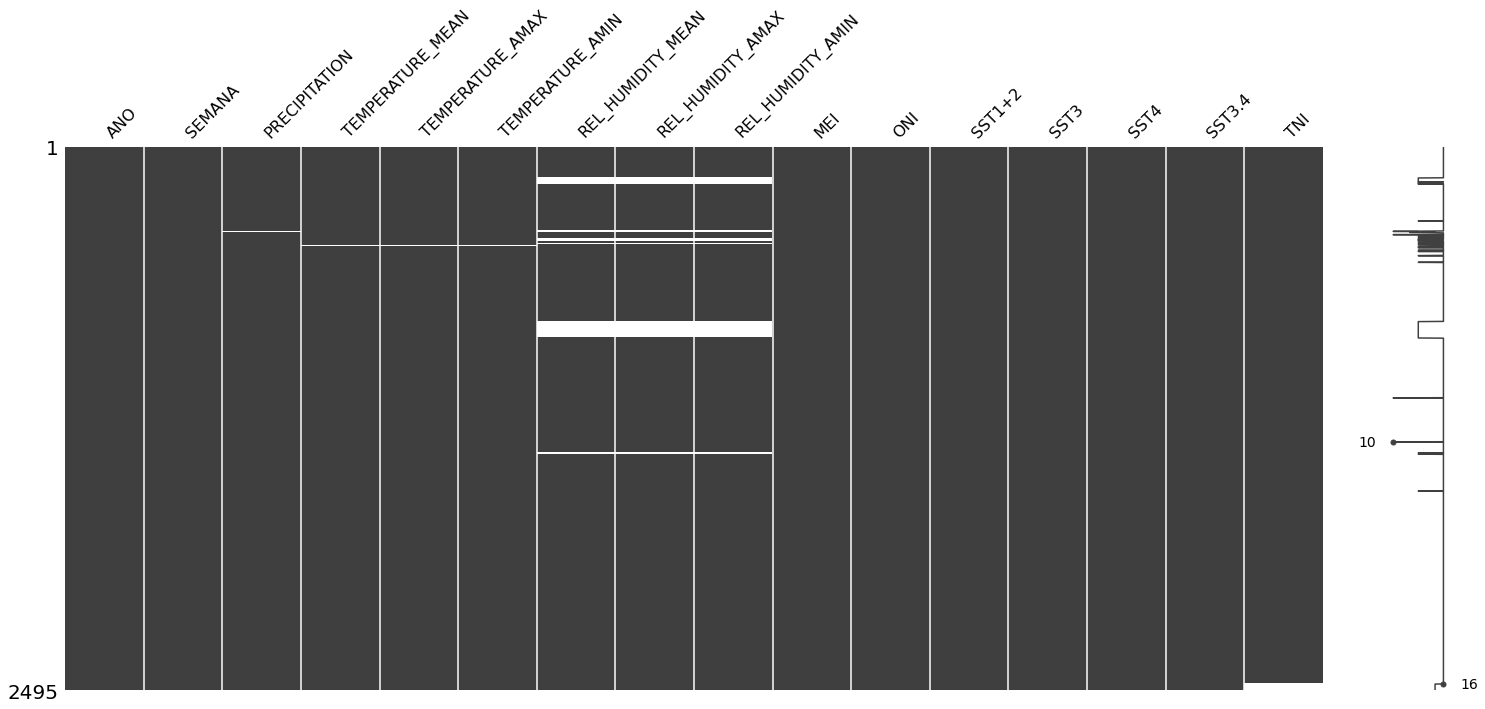

In [ ]:
%matplotlib inline
msno.matrix(df_daily)

<AxesSubplot:>

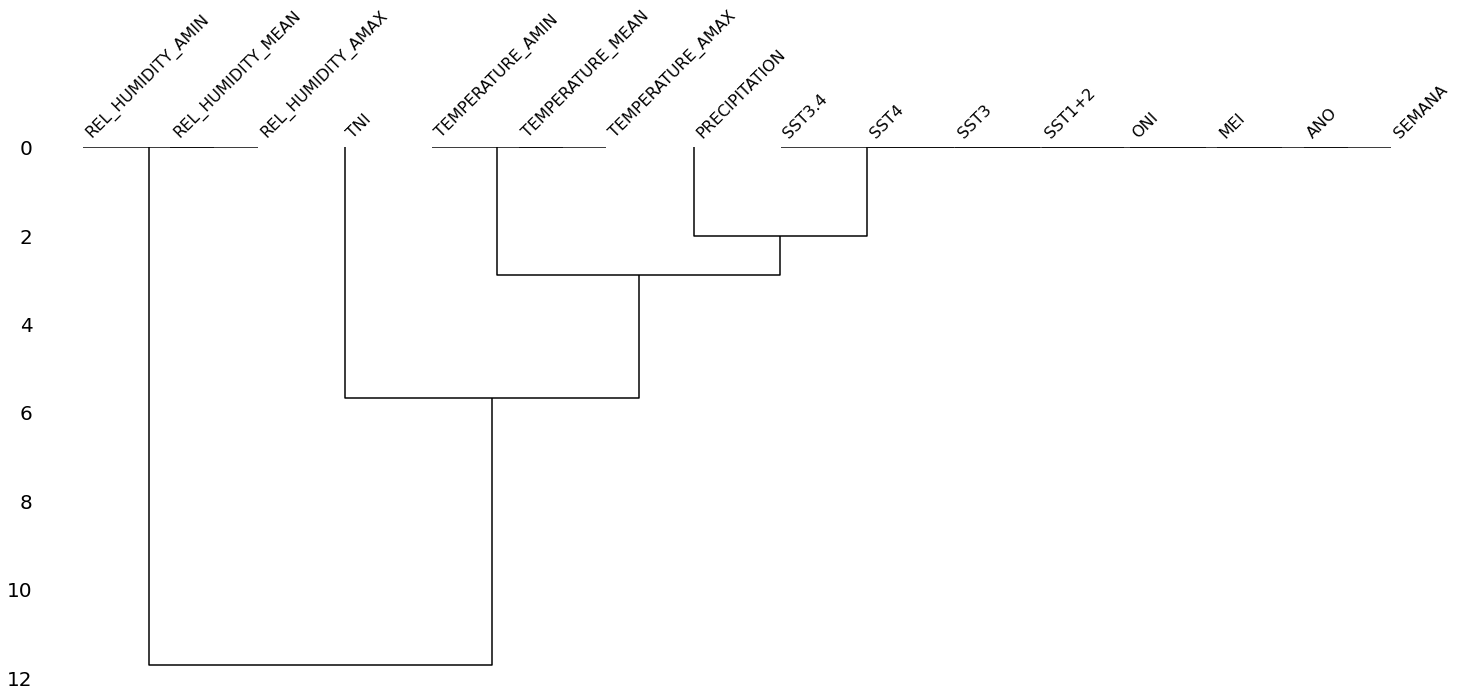

In [ ]:
msno.dendrogram(df_daily)


-----------------

### Missing values with imputer

In [ ]:
def imput_data_with_sklearn_imputer(df_daily):

    df_daily_interp = df_daily.copy()
    df_daily_interp["MES"] = df_daily_interp.index.month
    imputer= IterativeImputer(random_state=1)
    imputer.fit(df_daily_interp.values)
    imputted_vals = imputer.transform(df_daily_interp.values)
    df_daily_interp.loc[:,:] = imputted_vals
    return df_daily_interp

In [ ]:
df_daily_interp = imput_data_with_sklearn_imputer(df_daily)

### Missing values with Zach's suggested method

In [ ]:
def imput_data_with_closest_and_mean(df_daily):
    df_monthly_averages = df_daily[['PRECIPITATION', 'TEMPERATURE_MEAN',
           'TEMPERATURE_AMAX', 'TEMPERATURE_AMIN', 'REL_HUMIDITY_MEAN', 'REL_HUMIDITY_AMAX', 'REL_HUMIDITY_AMIN' ]]
    df_monthly_averages = df_monthly_averages.groupby(df_monthly_averages.index.month).mean()
    df_to_interpolate = df_daily[['PRECIPITATION', 'TEMPERATURE_MEAN',
       'TEMPERATURE_AMAX', 'TEMPERATURE_AMIN', 'REL_HUMIDITY_MEAN', 'REL_HUMIDITY_AMAX', 'REL_HUMIDITY_AMIN' ]].isna()
    df_daily_interp = df_daily.interpolate(method = "nearest")
    for col in df_monthly_averages:
        for idx in df_daily_interp.index:
            value = df_to_interpolate.loc[idx,col]
            if value == True:
                month = idx.month
                df_daily_interp.loc[idx,col] = (df_monthly_averages.loc[month, col] + df_daily_interp.loc[idx,col])/2
    return df_daily_interp

In [ ]:
df_daily_interp = imput_data_with_closest_and_mean(df_daily)

In [ ]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_daily_interp.index,
            y=df_daily_interp["TEMPERATURE_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="DAILY "+"TEMPERATURE"+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [ ]:
df_daily_interp["TEMPERATURE_RANGE"] = df_daily_interp["TEMPERATURE_AMAX"]  - df_daily_interp["TEMPERATURE_AMIN"] 
threshold_dry = 0.1 # Characteristics of consecutive dry days variations in China (2016)
df_daily_interp["DRY_DAYS"] = df_daily_interp["PRECIPITATION"].apply(lambda x: 1 if x < 0.1 else 0)
df_daily_interp.head()

,ANO,SEMANA,PRECIPITATION,TEMPERATURE_MEAN,TEMPERATURE_AMAX,TEMPERATURE_AMIN,REL_HUMIDITY_MEAN,REL_HUMIDITY_AMAX,REL_HUMIDITY_AMIN,MEI,ONI,SST1+2,SST3,SST4,SST3.4,TNI,MES,TEMPERATURE_RANGE,DRY_DAYS
FECHA,,,,,,,,,,,,,,,,,,,
2013-07-02,2013.0,27.0,0.0,28.400000,33.9,24.6,77.625000,92.0,57.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398,7.0,9.3,1
2013-07-03,2013.0,27.0,0.0,29.291667,33.4,25.6,79.416667,95.0,62.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398,7.0,7.8,1
2013-07-04,2013.0,27.0,0.0,29.420833,34.4,26.1,81.083333,99.0,59.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398,7.0,8.3,1
2013-07-05,2013.0,27.0,0.0,28.820833,33.9,24.8,81.130435,99.0,57.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398,7.0,9.1,1
2013-07-06,2013.0,27.0,0.0,28.983333,33.0,25.7,80.000000,99.0,64.0,-0.85,-0.38,20.29,24.97,28.76,26.91,-2.398,7.0,7.3,1


In [ ]:
df_daily_interp.columns

Index(['ANO', 'SEMANA', 'PRECIPITATION', 'TEMPERATURE_MEAN',
       'TEMPERATURE_AMAX', 'TEMPERATURE_AMIN', 'REL_HUMIDITY_MEAN',
       'REL_HUMIDITY_AMAX', 'REL_HUMIDITY_AMIN', 'MEI', 'ONI', 'SST1+2',
       'SST3', 'SST4', 'SST3.4', 'TNI', 'MES', 'TEMPERATURE_RANGE',
       'DRY_DAYS'],
      dtype='object')

In [ ]:
df_weekly_sums = df_daily_interp[["ANO","SEMANA","PRECIPITATION","DRY_DAYS"]].groupby(["ANO","SEMANA"]).sum().reset_index()
df_weekly_maxes = df_daily_interp[["ANO","SEMANA","TEMPERATURE_AMAX","REL_HUMIDITY_AMAX"]].groupby(["ANO","SEMANA"]).max().reset_index()
df_weekly_mins = df_daily_interp[["ANO","SEMANA","TEMPERATURE_AMIN","REL_HUMIDITY_AMIN"]].groupby(["ANO","SEMANA"]).min().reset_index()
df_weekly_means = df_daily_interp[['ANO', 'SEMANA', 'TEMPERATURE_MEAN','TEMPERATURE_RANGE','REL_HUMIDITY_MEAN', 'MEI','ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI']].groupby(["ANO","SEMANA"]).mean().reset_index()

In [ ]:
df_weekly = pd.merge(df_weekly_sums,df_weekly_maxes, how = "inner", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_mins, how = "inner", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_means, how = "inner", on = ["ANO","SEMANA"] )
df_weekly.head()

,ANO,SEMANA,PRECIPITATION,DRY_DAYS,TEMPERATURE_AMAX,REL_HUMIDITY_AMAX,TEMPERATURE_AMIN,REL_HUMIDITY_AMIN,TEMPERATURE_MEAN,TEMPERATURE_RANGE,REL_HUMIDITY_MEAN,MEI,ONI,SST1+2,SST3,SST4,SST3.4,TNI
0,2013.0,27.0,0.0,5,34.4,99.0,24.6,57.0,28.983333,8.360000,79.851087,-0.85,-0.380000,20.29,24.970000,28.760000,26.910000,-2.398000
1,2013.0,28.0,0.0,7,34.7,99.0,24.2,57.0,28.672619,8.485714,82.540420,-0.85,-0.380000,20.29,24.970000,28.760000,26.910000,-2.398000
2,2013.0,29.0,0.0,7,36.0,99.0,23.2,54.0,29.136905,8.842857,80.376701,-0.85,-0.380000,20.29,24.970000,28.760000,26.910000,-2.398000
3,2013.0,30.0,20.0,6,35.0,99.0,24.0,56.0,29.144455,7.771429,79.798360,-0.85,-0.380000,20.29,24.970000,28.760000,26.910000,-2.398000
4,2013.0,31.0,6.3,5,35.1,99.0,23.7,57.0,28.583489,8.328571,82.037366,-0.70,-0.367143,20.02,24.742857,28.738571,26.751429,-2.306714


# Dengue cases workflow

In [ ]:
df_dengue = pd.read_csv("./local/data/dengue_weekly_2007_2020.csv")

In [ ]:
df_dengue = df_dengue[df_dengue["COD_MUNICIPIO"]==cod_municipio]

In [ ]:
df_dengue["FECHA"] = pd.to_datetime(df_dengue["FECHA"])
df_dengue = df_dengue[(df_dengue["ANO"]>=2007)&(df_dengue["FECHA"]<pd.to_datetime("2020-05-01"))] #ajustando los casos de dengue para que queden hasta abril.
df_weekly["SEMANA"] = df_weekly["SEMANA"].astype('int')
df_weekly["ANO"] = df_weekly["ANO"].astype('int')

In [ ]:
df_weekly = pd.merge(df_weekly,df_dengue, how = "inner", on = ["ANO","SEMANA"] )

# Elevation and population workflow

In [ ]:
df_population = pd.read_csv("./local/data/data_per_year.csv")
df_population = df_population[df_population["COD_MUNICIPIO"]==cod_municipio]
df_population.head(5)

,ANO,COD_MUNICIPIO,COD_DPTO,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE,POBLACION
127,2006,8001,8,0,0,0,1154642.0
1218,2007,8001,8,2343,53,0,1162855.0
2309,2008,8001,8,2620,20,0,1170940.0
3400,2009,8001,8,1403,13,1,1178827.0
4491,2010,8001,8,2682,66,3,1186412.0


In [ ]:
df_municipios = pd.read_csv("./local/data/departments.csv")
df_municipios = df_municipios[df_municipios["COD_MUNICIPIO"]==cod_municipio]
df_municipios

,DEPARTAMENTO,MUNICIPIO,LATITUD,LONGITUD,COD_DPTO,COD_MUNICIPIO,ELEVACION
145,ATLANTICO,BARRANQUILLA,10.979967,-74.801309,8,8001,30.0


In [ ]:
df_weekly = pd.merge(df_weekly, df_population[["ANO","POBLACION"]], how = "left", on = "ANO")

In [ ]:
df_weekly.head(5)

,ANO,SEMANA,PRECIPITATION,DRY_DAYS,TEMPERATURE_AMAX,REL_HUMIDITY_AMAX,TEMPERATURE_AMIN,REL_HUMIDITY_AMIN,TEMPERATURE_MEAN,TEMPERATURE_RANGE,...,SST4,SST3.4,TNI,FECHA,COD_MUNICIPIO,COD_DPTO,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE,POBLACION
0,2013,27,0.0,5,34.4,99.0,24.6,57.0,28.983333,8.360000,...,28.760000,26.910000,-2.398000,2013-06-30,8001,8,91,5,0,1206946.0
1,2013,28,0.0,7,34.7,99.0,24.2,57.0,28.672619,8.485714,...,28.760000,26.910000,-2.398000,2013-07-07,8001,8,101,4,0,1206946.0
2,2013,29,0.0,7,36.0,99.0,23.2,54.0,29.136905,8.842857,...,28.760000,26.910000,-2.398000,2013-07-14,8001,8,90,0,0,1206946.0
3,2013,30,20.0,6,35.0,99.0,24.0,56.0,29.144455,7.771429,...,28.760000,26.910000,-2.398000,2013-07-21,8001,8,78,2,0,1206946.0
4,2013,31,6.3,5,35.1,99.0,23.7,57.0,28.583489,8.328571,...,28.738571,26.751429,-2.306714,2013-07-28,8001,8,84,1,0,1206946.0


In [ ]:
df_weekly = df_weekly.set_index(["FECHA","COD_DPTO","COD_MUNICIPIO","POBLACION"])
df_weekly = df_weekly.reset_index()
df_weekly = df_weekly.set_index("FECHA")
df_weekly

,COD_DPTO,COD_MUNICIPIO,POBLACION,ANO,SEMANA,PRECIPITATION,DRY_DAYS,TEMPERATURE_AMAX,REL_HUMIDITY_AMAX,TEMPERATURE_AMIN,...,MEI,ONI,SST1+2,SST3,SST4,SST3.4,TNI,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
FECHA,,,,,,,,,,,,,,,,,,,,,
2013-06-30,8,8001,1206946.0,2013,27,0.0,5,34.4,99.0,24.6,...,-0.850000,-0.380000,20.290000,24.970000,28.760000,26.910000,-2.398000,91,5,0
2013-07-07,8,8001,1206946.0,2013,28,0.0,7,34.7,99.0,24.2,...,-0.850000,-0.380000,20.290000,24.970000,28.760000,26.910000,-2.398000,101,4,0
2013-07-14,8,8001,1206946.0,2013,29,0.0,7,36.0,99.0,23.2,...,-0.850000,-0.380000,20.290000,24.970000,28.760000,26.910000,-2.398000,90,0,0
2013-07-21,8,8001,1206946.0,2013,30,20.0,6,35.0,99.0,24.0,...,-0.850000,-0.380000,20.290000,24.970000,28.760000,26.910000,-2.398000,78,2,0
2013-07-28,8,8001,1206946.0,2013,31,6.3,5,35.1,99.0,23.7,...,-0.700000,-0.367143,20.020000,24.742857,28.738571,26.751429,-2.306714,84,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-29,8,8001,1239518.0,2020,14,0.0,7,33.6,96.0,24.3,...,0.001429,0.370000,26.475714,27.761429,29.260000,28.105714,-1.785960,0,0,0
2020-04-05,8,8001,1239518.0,2020,15,0.0,7,36.9,98.0,26.0,...,-0.110000,0.280000,26.000000,28.010000,29.290000,28.320000,-1.634331,0,0,0
2020-04-12,8,8001,1239518.0,2020,16,0.0,7,34.6,98.0,24.4,...,-0.110000,0.280000,26.000000,28.010000,29.290000,28.320000,-1.719640,0,0,0


In [ ]:
df_weekly = df_weekly.iloc[0:-2,:] #borrando semanas excedentes, ya que los datos llegan hasta mayo pero el dengue solo está hasta mediados de abril
#df_weekly = df_weekly[df_weekly.ANO >= 2008]

In [ ]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_weekly.index,
            y=df_weekly["TEMPERATURE_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="WEEKLY "+"TEMPERATURE"+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [ ]:
df_weekly.to_csv("./local/data/barranquilla_consolidado_2013_2020.csv",index = True)